<a href="https://colab.research.google.com/github/aramirezfr/Facial-Recognition-with-Deep-Learning-Neural-Networks/blob/master/Facial_Recognition_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Recognition Binary Image Classifier:**
By: Adriana Ramirez Franco.\
Email: aramirezfr20@gmail.com\
Github: @aramirezfr

# Business Understanding:

### **About the Project:**  
This project focuses on developing a binary image classifier capable of distinguishing between human faces and non-face objects with high accuracy. The classifier will leverage advanced machine learning techniques to ensure reliable and efficient performance. The primary aim is to create a robust model that can be integrated into real-world applications such as smart surveillance systems, biometric authentication, and automated monitoring. By experimenting with various approaches, the project seeks to optimize performance and address the challenges associated with false positives and false negatives in face-object detection.

### **Why is This Problem Important to Solve?**  
In today's increasingly connected world, effective security and surveillance systems are critical for public safety and operational efficiency. Misidentifying faces as objects, or vice versa, can lead to inefficiencies, security risks, and missed opportunities for accurate monitoring. For instance, detecting unattended objects as potential threats or ensuring only authorized individuals access secure areas are vital for safety and operational integrity. Solving this problem enables smarter surveillance, reduces manual oversight, and enhances the accuracy of systems that rely on distinguishing human presence from inanimate objects. This has far-reaching implications for public safety, privacy, and the advancement of AI-driven security technologies.

### Benefits of Implementing Face Detection for Surveillance Systems:

1. **Enhanced Security**: Face detection allows surveillance systems to identify individuals in real time, helping to detect unauthorized access, locate persons of interest, and respond to security threats promptly.  

2. **Improved Efficiency**: Automating face detection reduces the need for continuous human monitoring, allowing security personnel to focus on critical events and reducing operational costs.  

3. **Threat Identification**: The system can distinguish human faces from unattended objects, such as bags or packages, enabling faster detection of potential security risks like abandoned luggage in crowded spaces.  

4. **Seamless Access Control**: Face detection systems can be integrated into biometric authentication systems to grant access only to authorized individuals, enhancing security in restricted areas.  

5. **Real-Time Analytics**: Face detection provides valuable data for real-time analytics, such as crowd density, movement patterns, and unusual activities, enabling smarter decision-making.  

6. **Scalability and Versatility**: These systems can be deployed across various environments, from airports and shopping malls to corporate offices and schools, offering scalable solutions for diverse security needs.  

7. **Privacy-Conscious Monitoring**: Advanced algorithms can focus on detecting faces without storing unnecessary personal data, ensuring compliance with privacy regulations while maintaining security.  

8. **Reduction in False Alarms**: By accurately distinguishing between faces and non-relevant objects, face detection systems reduce the occurrence of false alarms, leading to more efficient operations.  

By implementing face detection in surveillance systems, organizations can enhance public safety, improve operational efficiency, and foster trust in the reliability of security technologies.

# Data Understanding:

#### **Source and Properties of the data:**  


- **Tiny ImageNet Dataset**: This dataset contains a subset of the ImageNet dataset and includes 200 classes, with images of size 64x64 pixels. It is suitable for this project because it provides a diverse collection of object images that represent non-face entities. This diversity is critical to training a robust model that can reliably distinguish objects from faces in various scenarios.  
- **Labeled Faces in the Wild (LFW) Dataset**: This dataset contains 13,000 images of faces collected from the web, designed for face recognition tasks. It is highly suitable for this project as it provides a large number of labeled face images, enabling the model to learn distinct facial features and patterns.  

By combining these datasets, the project ensures a balanced representation of both classes (faces and objects), which is essential for building a reliable binary classifier.

For further details, refer to the Kaggle dataset page: (https://www.kaggle.com/datasets/jessicali9530/lfw-dataset) and (https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet/data)

#### **Size and descriptive Statistic Features:**  


- **Tiny ImageNet Dataset**: Contains 100,000 training images and 10,000 validation images. Images are RGB and resized to 64x64 pixels. The image size is around 1.5K.
- **LFW Dataset**: Contains over 13,000 images of faces, with varying lighting conditions, orientations, and resolutions. The image size is around 8K.

**Descriptive Statistics**:  
- **Features**: RGB pixel intensities (3 channels), normalized for preprocessing.  
- **Class Balance**: Steps will be taken to ensure equal representation of faces and objects during training to avoid bias in the model.  

#### **Feature Suitability:**  


The Pixel Intensities (RGB) feature capture the raw visual information required to distinguish between faces and objects.  
This Binary classification model requires clear distinctions between "face" and "object" classes, which these datasets provide through their labeling. The data variety in lighting, orientation, and object types ensures the model generalizes well to real-world scenarios, where inputs may vary significantly.

#### **Limitations of using this data:**  



- The images in both datasets have relatively **low resolutions**. While this helps with computational efficiency, it might limit the model’s ability to detect fine details, potentially affecting accuracy.  
- The Tiny ImageNet dataset is significantly larger than the LFW dataset, which could introduce **class imbalance**. To mitigate this, undersampling of the object class or oversampling of the face class may be required.  

By addressing these tasks and accounting for the limitations, the project will effectively leverage the strengths of these datasets to build a high-performing face vs. object classifier.

# Data Preparation:

I will begin by importing all the necessary libraries for this project.

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sns
import math
from PIL import Image
import matplotlib.image as mpimg
from scipy.stats import randint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

---------------------------------------

I will be using the face dataset to train my model. I need to set the face dataset as the positive (1) outcome of the model.
I will also use the object dataset as the negative (0) outcome.

## Face Dataset:

I will begin downloading the necessary files from Kaggle, unzip both files needed and Importing the necessary libraries for this project.

In [5]:
#Downloading the data file from Kaggle
#uncomment line 3 to run
#!kaggle datasets download -d jessicali9530/lfw-dataset

In [6]:
#Unzip the data folder
#uncomment line 3 to run
#!unzip lfw-dataset.zip -d data

Setting all of the images from the files into one file that will contain only the images we need to use.

In [7]:
#defining root directory
face_root_dir = 'data/lfw-deepfunneled/lfw-deepfunneled/'

#list to store all jpeg file paths
face_jpg_files = []

for dirpath, dirnames, files in os.walk(face_root_dir):
    for file in files:
        #check if the file ends with .jpg
        if file.endswith('.jpg'):
            #construct the full file path
            full_path = os.path.join(dirpath, file)
            #append to the list
            face_jpg_files.append(full_path)

Getting the number of images (strings) in the file.

In [8]:
len(face_jpg_files)

13233

We have 13,233 face images that we can use to build a model.

-------------

## Objects Dataset:

As with the Face dataset, I will download, unzip and put all images into one file.

In [11]:
# Downloading the data file from Kaggle of the objects
#!kaggle datasets download -d akash2sharma/tiny-imagenet #uncomment before running

In [12]:
#unzip the data folder
#!unzip tiny-imagenet.zip -d data #uncomment to run

Setting all of the images into one folder.

In [59]:
object_root_dir = 'data/tiny-imagenet-200/'
object_jpg_files = []

for dirpath, dirnames, files in os.walk(object_root_dir):
    for file in files:
        #check if the file ends with .JPEG
        if file.endswith('.JPEG'):
            #construct the full file path
            full_path = os.path.join(dirpath, file)
            #append to the list
            object_jpg_files.append(full_path)

In [14]:
#checking the quantity of images in objects dataset
len(object_jpg_files)

240000

We got a count of 240,000 because there is another file with 120,000 images inside the one with already 120,000. Could be interpreted like duplicates. We will remove the extra folder, to just keep the 120,000 unique images that the file should contain.

In [15]:
#removing the extra folder
import shutil
shutil.rmtree('data/tiny-imagenet-200/tiny-imagenet-200', ignore_errors=True)

In [16]:
#setting up the file for objects images again
object_root_dir = 'data/tiny-imagenet-200/'
object_jpg_files = []

for dirpath, dirnames, files in os.walk(object_root_dir):
    for file in files:
        #check if the file ends with .JPEG
        if file.endswith('.JPEG'):
            #construct the full file path
            full_path = os.path.join(dirpath, file)
            #append to the list
            object_jpg_files.append(full_path)

In [17]:
#checking the count of images
len(object_jpg_files)

120000

There are 120,000 files in the dataset, that is about 10 times more than the faces dataset. I will use a random sample of 12,000 images of objects so the data gets more balanced.

In [18]:
import random
random.seed(42)

#randomly sample 12,000 images from the path
tinyobject_jpg_files = random.sample(object_jpg_files, 12000)

#verify the length of the reduced list
print(f"Number of object images selected: {len(tinyobject_jpg_files)}")

Number of object images selected: 12000


Now that we have a more balanced data, I want to take a look at how the images on both sets look like.

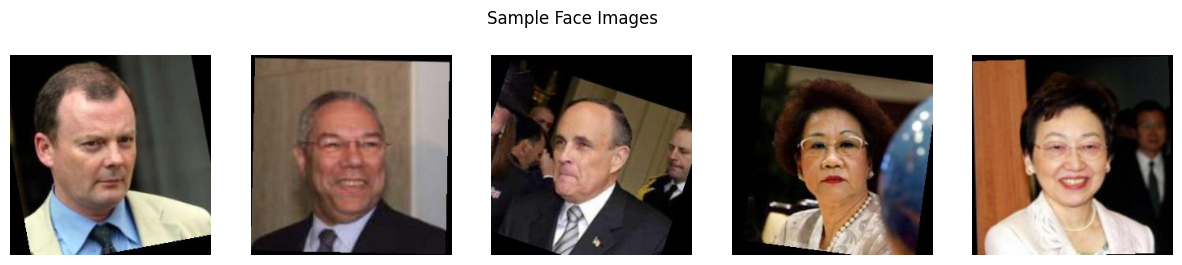

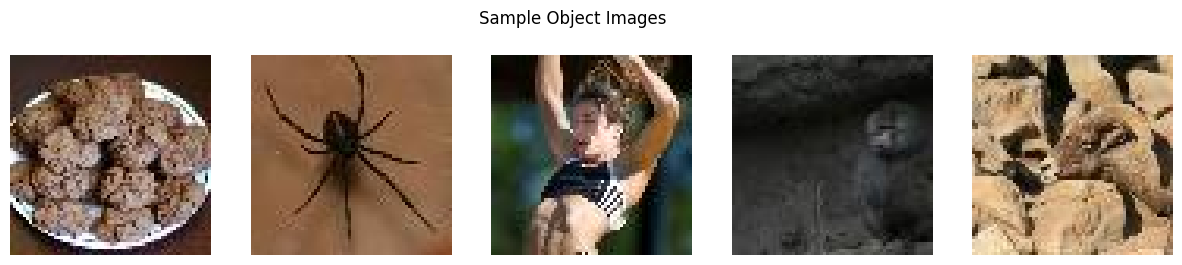

In [19]:
#display images from objects and faces dataset
#randomly select images from each category
num_samples = 5
random.seed(42)
sample_face_images = random.sample(face_jpg_files, num_samples)
sample_tinyobject_images = random.sample(tinyobject_jpg_files, num_samples)

#function to display images
from PIL import Image
def display_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#display face images
display_images(sample_face_images, "Sample Face Images")

#display object images
display_images(sample_tinyobject_images, "Sample Object Images")

I could see that the image quality is definitely different between face and non-face images. Face images are 8K of size, while non-face images are about 1.5K big. Face images are about 5 times bigger than non-face ones.

------------------------

## Split:

In this section of the project I will separate the face and non-face images into Training, Validation and Testing data.

In [20]:
#function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0
    return image, label

#batch size
batch_size = 32

In [21]:
#creating labels for each set
face_labels = [1] * len(face_jpg_files)  #positive class for faces
tinyobject_labels = [0] * len(tinyobject_jpg_files)  #negative class for objects

#combine lists and labels
all_images = face_jpg_files + tinyobject_jpg_files
all_labels = face_labels + tinyobject_labels

In [22]:
#convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [23]:
#convert to TensorFlow Dataset
images_ds = tf.data.Dataset.from_tensor_slices(all_images)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
dataset = tf.data.Dataset.zip((images_ds, labels_ds))

In [24]:
#define the target image size
img_height = 64
img_width = 64

In [25]:
#apply the preprocessing function
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

Splitting the data two times.\
**First split:** will separate the data into training data(0.70) and temporary data (0.30).\
**Second split:** separates the temporary data into validation(0.15) and testing (0.15).

In [26]:
from sklearn.model_selection import train_test_split
#first split
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
#second split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

**Resulting proportions:**
- X_train: 70% of the total data
- X_val: 15% of the total data
- X_test: 15% of the total data

In [27]:
#checking the count of images in all the sets
print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Training set: 17663 images
Validation set: 3785 images
Test set: 3785 images


Setting up a bar graph to visualize the count of data in each set.

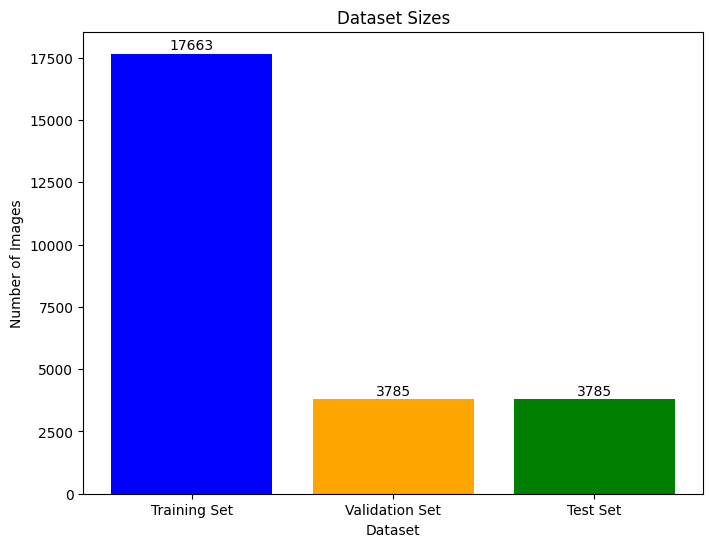

In [70]:
#sizes of each dataset
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

#labels and sizes
categories = ['Training Set', 'Validation Set', 'Test Set']
sizes = [train_size, val_size, test_size]

#plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, sizes, color=['blue', 'orange', 'green'])
plt.title('Dataset Sizes')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
#save the bar graph as a .JPG image
plt.savefig("dataset_sizes.jpg")

#display the values on top of the bars
for i, size in enumerate(sizes):
    plt.text(i, size + max(sizes) * 0.01, str(size), ha='center')
plt.show()

In [29]:
#creating a TensorFlow Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

#create validation and test datasets
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
#function to set up datasets for the decision tree and random forest
def load_and_preprocess_image_dt(path):
    """Loads and preprocesses a single image."""
    image = Image.open(path).convert('RGB')
    image = image.resize((64, 64))
    image = np.array(image) / 255.0
    return image.flatten()  #1D array

#preprocess the training data
X_train_processed_dt = np.array([load_and_preprocess_image_dt(path) for path in X_train])

#preprocess the validation data
X_val_processed_dt = np.array([load_and_preprocess_image_dt(path) for path in X_val])

#preprocess test data
X_test_processed_dt = np.array([load_and_preprocess_image_dt(path) for path in X_test])

Getting variables needed for hyperparameter tuning.

In [61]:
#extract images and labels from the datasets
X_train_images, y_train_labels = tuple(zip(*train_dataset))
X_val_images, y_val_labels = tuple(zip(*val_dataset))
X_test_images, y_test_labels = tuple(zip(*test_dataset))

#convert to arrays
X_train_images = np.concatenate(list(X_train_images))
y_train_labels = np.concatenate(list(y_train_labels))
X_val_images = np.concatenate(list(X_val_images))
y_val_labels = np.concatenate(list(y_val_labels))
X_test_images = np.concatenate(list(X_test_images))
y_test_labels = np.concatenate(list(y_test_labels))


# Model:

**Model building** is an iterative process that begins with developing a baseline model, which serves as a reference point for comparison. Each subsequent model iteration will be designed with clear justifications based on the performance of previous models. \
- By systematically refining and evaluating these iterations, the goal is to identify the model that delivers the best performance for this binary classification task.

## Model with Simple decision trees and random forest:

For this section, I created two basic models: Decision Trees (model 1) and Random Forest (model 2). I did not add any parameters to either model to observe their performance in their simplest forms.

In [32]:
#Simple Decision Tree Model 1
dt_classifier = DecisionTreeClassifier() #instantiate
dt_classifier.fit(X_train_processed_dt, y_train) #fit
dt_val_predictions = dt_classifier.predict(X_val_processed_dt) #predictions

#calculate accuracy
dt_accuracy = accuracy_score(y_val, dt_val_predictions)
print(f"Decision Tree Validation Accuracy: {dt_accuracy}")

Decision Tree Validation Accuracy: 0.9603698811096433


In [33]:
#Simple Random Forest Model 2
rf_classifier = RandomForestClassifier() #instantiate
rf_classifier.fit(X_train_processed_dt, y_train) #fit
rf_val_predictions = rf_classifier.predict(X_val_processed_dt) #predictions
rf_accuracy = accuracy_score(y_val, rf_val_predictions) #get acc score
print(f"Random Forest Validation Accuracy: {rf_accuracy}")

Random Forest Validation Accuracy: 0.9870541611624835


**Results:**
- **Decision Tree Validation Accuracy:** Achieves accurate predictions 96% of the time.
- **Random Forest Validation Accuracy:** Achieves accurate predictions 98.7% of the time.

This means that the Random Forest model is slightly more accurate than the Decision Tree model in making predictions.

## CNN Model:

I named this model **base_model** (baseline model) since it is my first attempt at creating a Convolutional Neural Network (CNN).

In [34]:
#define a simple CNN model
base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
#compile the model
base_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#train the model
base_model_hist=base_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.9353 - loss: 0.1451 - val_accuracy: 0.9982 - val_loss: 0.0080
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9947 - loss: 0.0158 - val_accuracy: 0.9982 - val_loss: 0.0042
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9979 - val_loss: 0.0083
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.9982 - loss: 0.0043 - val_accuracy: 0.9950 - val_loss: 0.0143
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9921 - val_loss: 0.0322
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9966 - val_loss: 0.0100
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9981 - loss: 0.0039 - val_accuracy: 0.9968 - val_loss: 0.0121
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9994 - loss: 0.0018 - 

In [38]:
# Evaluate the model
results_base_train=base_model.evaluate(test_dataset)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9977 - loss: 0.0036


The model achieved an impressive accuracy of 99.77% with a very low loss of 0.0036, indicating it performs exceptionally well on the given task.

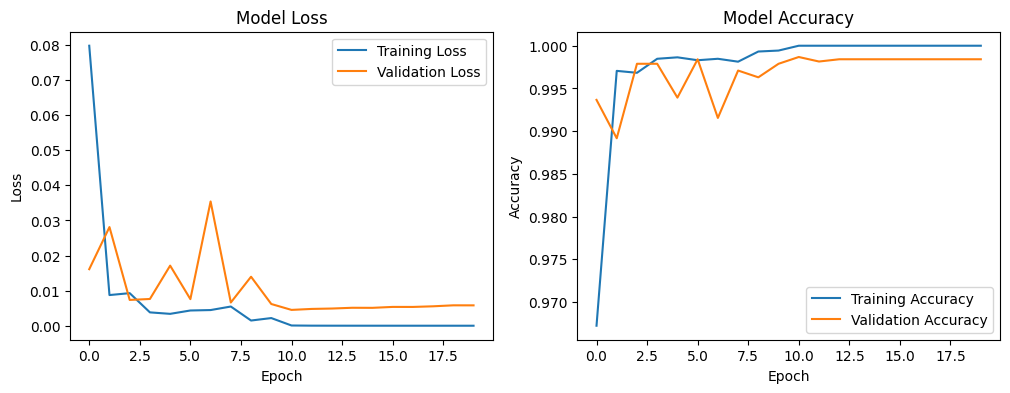

In [72]:
#plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(base_model_hist.history['loss'], label='Training Loss')
plt.plot(base_model_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("cnnmodel_loss.jpg")
plt.legend()

#plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(base_model_hist.history['accuracy'], label='Training Accuracy')
plt.plot(base_model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("cnn_modelacc.jpg")
plt.show()

## Hyperparameter tuning on the CNN Model:

Creating a different model for hyperparameter tuning allows me to explore various configurations to optimize performance, improve accuracy, and prevent overfitting. This approach ensures the model is flexible, efficient, and well-suited to the specific characteristics of the dataset.

In [40]:
pip install -q -U keras-tuner #uncomment if you need to install kerastuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [41]:
from kerastuner import RandomSearch

#creating a function for the model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        input_shape=(img_height, img_width, 3)
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #compile the Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

#set up the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of different hyperparameter combinations to try
    executions_per_trial=3,  # Number of models to build and fit for each trial
    directory='my_dir',
    project_name='image_classifier_tuning'
)

#run the hyperparameter search
#assume you have your data prepared as train_images, train_labels, val_images, val_labels
tuner.search(X_train_images, y_train_labels, epochs=10, validation_data=(X_val_images, y_val_labels))

#retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 34m 48s]
val_accuracy: 0.9985028704007467

Best val_accuracy So Far: 0.9985028704007467
Total elapsed time: 01h 20m 10s


- The result indicates that after performing hyperparameter tuning on another CNN model, we achieved a validation accuracy of approximately 99.85% in Trial 3. This is the highest validation accuracy obtained so far.
- The total time spent on hyperparameter tuning was 1 hour, 20 minutes, and 10 seconds.

This high validation accuracy suggests that the hyperparameter tuning significantly improved the model's performance, making it highly accurate on the validation dataset.

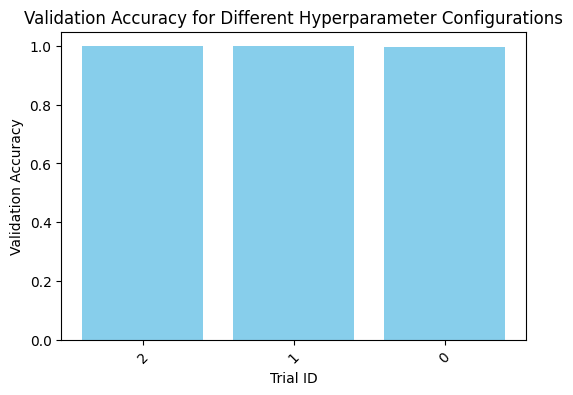

In [71]:
# Get the results as a dataframe
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Create a DataFrame to store the results
results = []
for trial in tuner_results:
    trial_result = {
        'Trial ID': trial.trial_id,
        'Val Accuracy': trial.score  # Assuming 'val_accuracy' is used as the objective
    }
    # Append hyperparameters with their values
    trial_result.update(trial.hyperparameters.values)
    results.append(trial_result)

results_df = pd.DataFrame(results)

# Plotting the validation accuracy for each trial
plt.figure(figsize=(6, 4))
plt.bar(results_df['Trial ID'], results_df['Val Accuracy'], color='skyblue')
plt.xlabel('Trial ID')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Hyperparameter Configurations')
plt.xticks(rotation=45)
plt.savefig("hyperpara_trialaccuracy.jpg")
plt.show()

# Evaluation:

**Evaluation of the best CNN Hyperparameter-tuned Model:**
Conducting a final evaluation of the best hyperparameter-tuned CNN model is crucial to validate its performance, ensure generalization to new data, and confirm the reliability and robustness of the model for real-world applications.

In [63]:
#retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

#train
history = best_model.fit(X_train_images, y_train_labels, epochs=10, validation_data=(X_val_images, y_val_labels))

#evaluate
evaluation = best_model.evaluate(X_test_images, y_test_labels)
print(f"Test Accuracy: {evaluation[1]}")

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 57s 102ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9979 - val_loss: 0.0041
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 1.0000 - loss: 1.2841e-04 - val_accuracy: 0.9987 - val_loss: 0.0034
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 1.0000 - loss: 1.2811e-04 - val_accuracy: 0.9987 - val_loss: 0.0029
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 1.0000 - loss: 3.9587e-05 - val_accuracy: 0.9984 - val_loss: 0.0033
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 59s 106ms/step - accuracy: 1.0000 - loss: 2.4273e-05 - val_accuracy: 0.9987 - val_loss: 0.0031
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 1.0000 - loss: 1.8357e-05 - val_accuracy: 0.9982 - val_loss: 0.0036
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 1.0000 - loss: 6.0726e-05 - val_accuracy: 0.9963 - val_loss: 0.0117
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - ac

**Evaluation of Final Model Performance:**
- The final model, optimized through hyperparameter tuning, achieved a test **accuracy of 99.92%**.
- However, this high accuracy may not be entirely reliable due to the lack of downscaling of face images and potential overfitting.
- The model might be leveraging the size difference between face and non-face images rather than learning meaningful features.

**Justification of Metrics:**
- The primary metric used for evaluation is **accuracy**, which measures the proportion of correct predictions out of the total predictions.
- The near-perfect score suggests **overfitting**. This indicates that the model performs well on the training data but may not generalize effectively to new, unseen data.

**Runtime:**
- The hyperparameter tuning and model training process took a total of 1 hour, 20 minutes, and 10 seconds.
- This runtime includes the search for optimal hyperparameters and the training of the final model.

 Despite the efficient use of computational resources and time, further steps are needed to ensure the model's reliability and generalization.

**Classification Report:**\
  A classification report offers a comprehensive view of the model's strengths and weaknesses, guiding further improvements and ensuring the model's reliability and fairness.

In [64]:
#getting predictions
y_pred = best_model.predict(X_test_images)
y_pred_classes = (y_pred > 0.5).astype("int32")

#generate the classification report
report = classification_report(y_test_labels, y_pred_classes)
print(report)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1800
           1       1.00      1.00      1.00      1985

    accuracy                           1.00      3785
   macro avg       1.00      1.00      1.00      3785
weighted avg       1.00      1.00      1.00      3785



**Confusion Matrix**

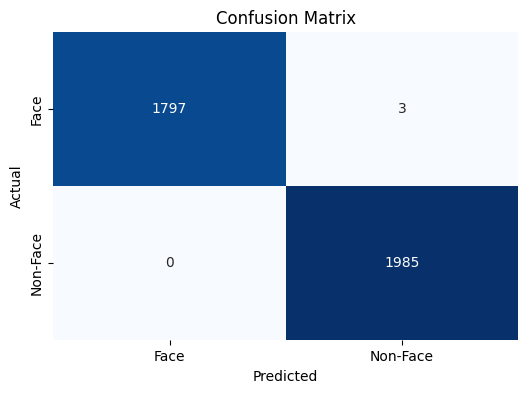

In [73]:
#generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_classes)

#plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[ 'Face', 'Non-Face'], yticklabels=[ 'Face', 'Non-Face'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.jpg")
plt.show()

# Results:

The hyperparameter-tuned model achieved outstanding results, with a test **accuracy of 99.92%**. The classification report further confirmed this performance, showing perfect precision, recall, and F1-scores of 1.00 for both classes (faces and non-faces). The confusion matrix also reflected this high accuracy, with no misclassifications. These results indicate that the model performs exceptionally well in distinguishing between faces and non-faces, although the high accuracy suggests potential overfitting due to the image size discrepancy between the datasets.

### **Limitations Found:**

1. **Image Size**: The face images from the LFW dataset are significantly larger (approximately 8k) compared to the object images from the Tiny ImageNet dataset (around 1.5k). This size difference likely contributes to overfitting, as the model may distinguish between faces and non-faces based on image size rather than features.
   
2. **Dataset Imbalance**: There is an imbalance in the number of face and non-face images, which can lead to biased model performance. If one class is overrepresented, the model might perform well on that class but poorly on the underrepresented class.

3. **Overfitting**: The models achieving nearly 100% accuracy suggest overfitting, where the model performs exceptionally well on the training data but fails to generalize to new, unseen data.

4. **Data Quality**: Variations in image quality, lighting conditions, and backgrounds in the datasets can affect model performance. Inconsistent data quality can lead to a model that is sensitive to these variations and less robust.

5. **Feature Extraction**: The current model architecture may not be optimal for distinguishing between faces and non-faces. More advanced feature extraction techniques or different model architectures might be needed to improve performance.

## Next Steps:

1. **Image Downscaling**: Downscale the face images to match the size of the object images, ensuring uniformity in image dimensions. This will help the model evaluate all images on an equal basis and potentially reduce overfitting.

2. **Data Augmentation**: Apply data augmentation techniques such as rotation, flipping, and cropping to increase the diversity of the training data. This can help the model generalize better to new data.

3. **Regularization Techniques**: Implement regularization techniques such as dropout, L2 regularization, or early stopping to prevent overfitting and improve model generalization.

4. **Advanced Architectures**: Experiment with more advanced model architectures, such as deeper Convolutional Neural Networks (CNNs) or transfer learning with pre-trained models, to enhance feature extraction and improve classification performance.

5. **Cross-Validation**: Use cross-validation to better assess the model's performance and ensure that it generalizes well to different subsets of the data.

By addressing these limitations and following the previous steps, we can improve the robustness and accuracy of the face recognition model without overfitting.